# Unsupervised anomaly detection (fraud) algorithm

This notebook has good example algorithms to do a forensic-type analysis, looking for anomalies in a dataset. We first do some data cleaning (exclusions, imputation), then build variables that are designed to look for the kinds of anomalies we are interested in, in this case, unusual property valuations.

After we build the variables we know we have lots of correlations and too high dimensionality so we need to remove correlations and reduce dimensionality. Since we don't have a dependent variable the easiest useful thing to do is PCA. We z scale, do PCA, keep the top PCs, then z scale again in order to make each retained PC equally important (optional step).

We use two different anamaly detection (fraud) algorithms. The first just looks for outliers in the final scaled PC space using a Minkowski distance from the origin. The second method makes a simple autoencoder and the fraud score is then the reproduction error. It's important to note that each/either of these two methods would be a fine fraud score by itself.

Since we have two score and we don't really know which one is better we just average the two scores. To do this we replace the score with its rank order and then average the rank-ordered scores for our final score.

Finally we sort all the records by this final score and explore the top n records. To help the investigation we show which of the variables are driving these top scoring records with a heat map of the variable zscores, which can point the investigators to what's making the high score for these top scoring records.

This problem is an invented problem to demonstrate the process of building unsupervised fraud models. The data set is real and the invented problem is realistic. What's lacking the most is the ability to interact with domain experts in order to do proper exclusions and design good/appropriate variables.

The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [480]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 6 seconds

LOAD DURATION: 0:00:00.082798


In [481]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 2.56 s, sys: 1.48 s, total: 4.04 s
Wall time: 9.45 s


(1070994, 32)

In [482]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [483]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some benign properties that we aren't interested in
There are certainly better ways to do this, and this important step can/should be improved.

In [484]:
# first look at the most frequent owners
remove_list = data['OWNER'].value_counts().head(20).index.tolist()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [485]:
# remove some of these and add some others to also be removed
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.append('UNITED STATES OF AMER')
remove_list.append('U S GOVERNMENT OWNRD')
remove_list.append('THE CITY OF NEW YORK')
remove_list.append('NYS URBAN DEVELOPMENT')
remove_list.append('NYS DEPT OF ENVIRONME')
remove_list.append('CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI')
remove_list.append('DEPT RE-CITY OF NY')
remove_list.append('NY STATE PUBLIC WORKS')
remove_list.append('NYC DEPT OF HIGHWAYS')
remove_list.append("NYC DEP'T OF HIGHWAYS")
remove_list.append('CITY WIDE ADMINISTRAT')
remove_list.append('DEPT OF PUBLIC WORKS')
remove_list.append('NEW YORK CITY')
remove_list.append('THE PORT OFNY & NJ')
remove_list.append('NYC DEPT OF PUB WORKS')
remove_list.append('NEW YORK STATE DEPART')
remove_list.append('CITY AND NON-CITY OWN')

In [486]:
property_data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
property_data.shape

(1046516, 32)

In [487]:
data.shape

(1070994, 32)

In [488]:
# this is how many records we removed
len(data) - len(property_data)

24478

In [489]:
numrecs = len(property_data)

## Fill in missing ZIP

In [490]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21537

In [491]:
# Assume the data is already sorted by zip. If a zip is missing, 
# and the before and after zips are the same, fill in the zip with that value
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [492]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10114

In [493]:
# For the remaining missing zips, just fill in with the previous record's zip.
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [494]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [495]:
property_data['FULLVAL'].replace('NaN',0)
temp =property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     8.510005e+04
4     2.713604e+06
Name: FULLVAL, dtype: float64


In [496]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [497]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [498]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

CPU times: user 1.87 s, sys: 206 ms, total: 2.07 s
Wall time: 3.69 s


In [499]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in the missing STORIES

In [500]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43684

In [501]:
temp['TAXCLASS'].value_counts()

1B    19000
4     17768
2      3434
3      2398
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [502]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111631
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.745047
3      1.000000
4      5.517525
Name: STORIES, dtype: float64


In [503]:
temp.head().transpose()

,0,1,59,60,61
RECORD,1,2,66,67,68
BBLE,1000010101,1000010201,1000051004,1000051005,1000051006
BORO,1,1,1,1,1
BLOCK,1,1,5,5,5
LOT,101,201,1004,1005,1006
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,SLG BROAD STREET 125
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


In [504]:
len(property_data[property_data["STORIES"]==0])

0

In [505]:
property_data['STORIES']=property_data['STORIES'].fillna(value =0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]

In [506]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [507]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# We think zero and 1 are invalid values for these fields, so replace them wiht NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

# Now impute values with the average for that record's TAXCLASS
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

In [508]:
mean_LTFRONT

TAXCLASS
1      30.939123
1A     51.130890
1B     46.236157
1C     27.250825
1D    338.275862
2     111.579150
2A     25.919459
2B     27.254800
2C     29.990000
3     154.246053
4      82.137226
Name: LTFRONT, dtype: float64

In [509]:
mean_LTDEPTH

TAXCLASS
1      99.278967
1A     90.095778
1B    104.046130
1C     96.778878
1D    497.827586
2     130.815876
2A     97.288381
2B     95.725639
2C     95.747557
3     273.994553
4     124.231567
Name: LTDEPTH, dtype: float64

In [510]:
mean_BLDFRONT

TAXCLASS
1     21.403236
1A    25.026348
1B    39.500000
1C    23.367589
1D    19.586207
2     91.495779
2A    22.985669
2B    26.033148
2C    27.887866
3     10.000000
4     62.059559
Name: BLDFRONT, dtype: float64

In [511]:
mean_BLDDEPTH

TAXCLASS
1      41.560512
1A     44.952387
1B     82.666667
1C     60.094862
1D     36.862069
2     104.282570
2A     62.435640
2B     66.521339
2C     68.658517
3      17.500000
4      86.275049
Name: BLDDEPTH, dtype: float64

In [512]:
data = property_data.copy()
data.shape

(1046516, 32)

In [513]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [514]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [515]:
data.count()

RECORD      1046516
BBLE        1046516
BORO        1046516
BLOCK       1046516
LOT         1046516
EASEMENT       2762
OWNER       1014771
BLDGCL      1046516
TAXCLASS    1046516
LTFRONT     1046516
LTDEPTH     1046516
EXT          353364
STORIES     1046516
FULLVAL     1046516
AVLAND      1046516
AVTOT       1046516
EXLAND      1046516
EXTOT       1046516
EXCD1        625079
STADDR      1046053
ZIP         1046516
EXMPTCL       10467
BLDFRONT    1046516
BLDDEPTH    1046516
AVLAND2      267195
AVTOT2       267201
EXLAND2       82171
EXTOT2       119170
EXCD2         92912
PERIOD      1046516
YEAR        1046516
VALTYPE     1046516
zip3        1046516
dtype: int64

In [516]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [517]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [518]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [519]:
# add in the inverse of all the 9 primary variables
epsilon = .01
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col] + epsilon)

In [520]:
vars18 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9',
          'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']
zip5_mean = data.groupby('ZIP')[vars18].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [521]:
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])

In [522]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
...,...,...,...,...,...
r6inv_taxclass,0.000995,0.000294,0.059675,0.041345,0.03929
r7inv_taxclass,0.068946,0.000049,0.007301,0.005052,0.002717
r8inv_taxclass,0.00086,0.000095,0.004664,0.003227,0.001736
r9inv_taxclass,0.000934,0.000103,0.045842,0.031735,0.017076


In [523]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r1inv',
       'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv', 'r7inv', 'r8inv', 'r9inv',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1inv_zip5', 'r2inv_zip5',
       'r3inv_zip5', 'r4inv_zip5', 'r5inv_zip5', 'r6inv_zip5', 'r7inv_zip5',
       'r8inv_zip5', 'r9inv_zip5', 'r1_taxclass', 'r2_taxclass', 'r3_taxclass',
       'r4_taxclass', 'r5_taxclass', 'r6_taxclass', 'r7_taxclass',
       'r8_taxclass', 'r9_taxclass', 'r1inv_taxclass', 'r2inv_taxclass',
       'r3inv_taxclass',

In [524]:
save_record = data['RECORD']
save_record.head()

0     1
1     2
2     9
3    10
4    11
Name: RECORD, dtype: int64

In [525]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1046516, 55)

In [526]:
data.head().transpose()

,0,1,2,3,4
r1,40.917782,57777.406626,386.588395,558.693624,1038.804619
r2,3996.868587,36195.940760,736.761464,1064.760189,1979.757338
r3,724.395187,6560.176972,14.735229,21.295204,39.595147
r4,8.079350,4266.226465,62.337391,90.089449,94.815422
r5,789.194776,2672.672406,118.802810,171.692774,180.699549
r6,143.034199,484.396968,2.376056,3.433855,3.613991
r7,18.413002,25999.832982,173.964788,251.412180,467.462079
r8,1798.590864,16288.173342,331.542677,479.142178,890.890802
r9,325.977834,2952.079637,6.630854,9.582844,17.817816
r1inv,0.024433,0.000017,0.002587,0.001790,0.000963


In [527]:
stats =data.describe().transpose()
stats.to_excel('stats_on_var.xlsx')

<ipython-input-527-07170817ee09>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  stats.to_excel('stats_on_var.xlsx')


<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


CPU times: user 13.1 s, sys: 21 s, total: 34.1 s
Wall time: 1min 37s


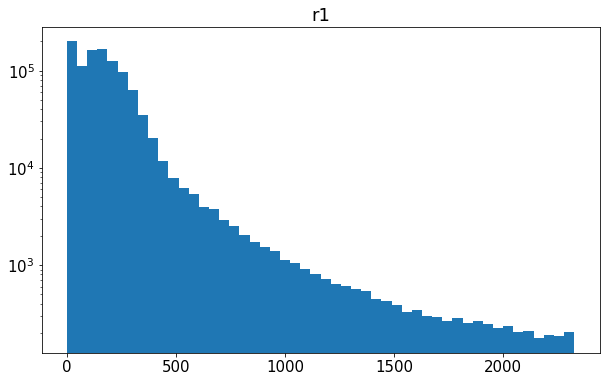

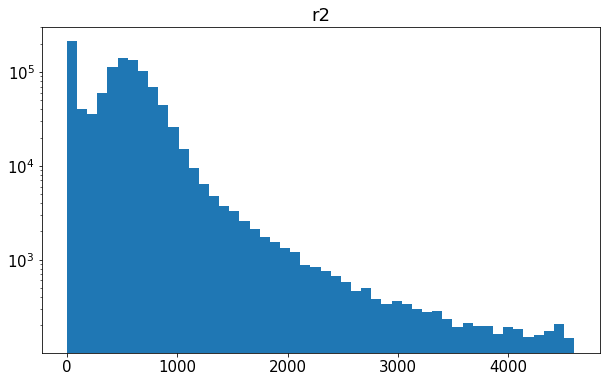

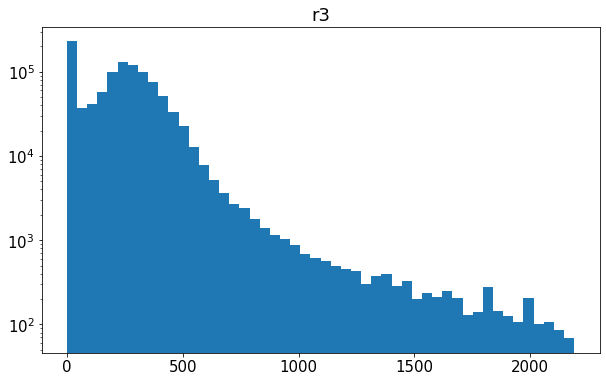

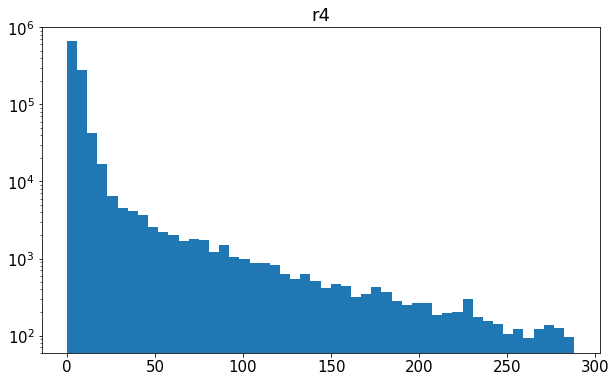

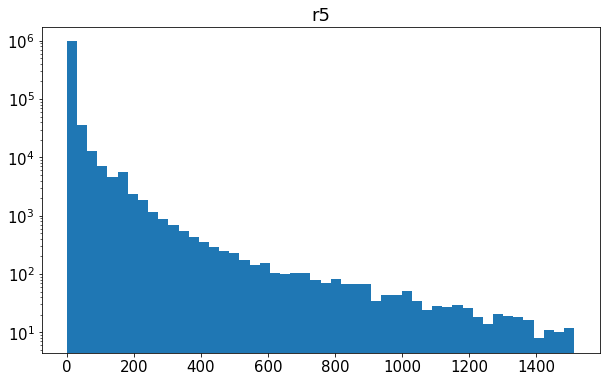

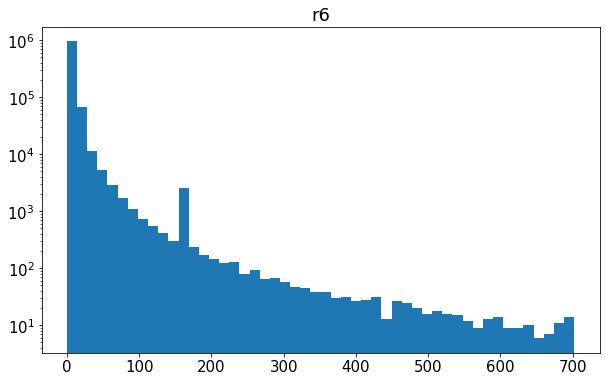

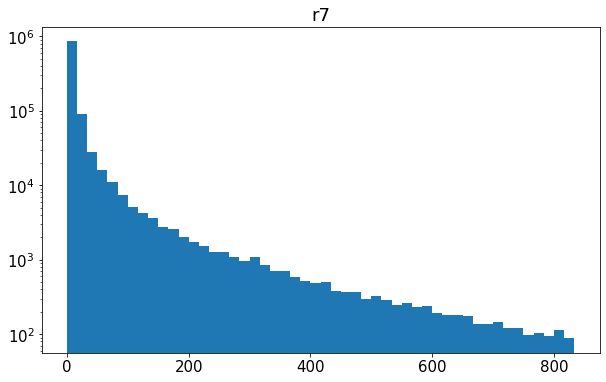

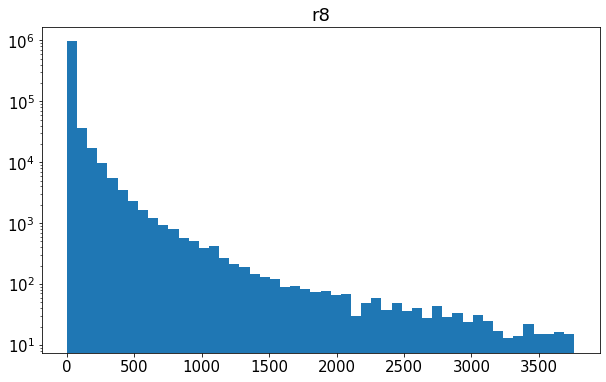

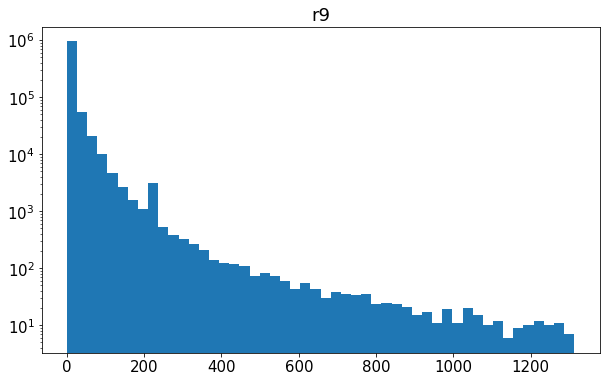

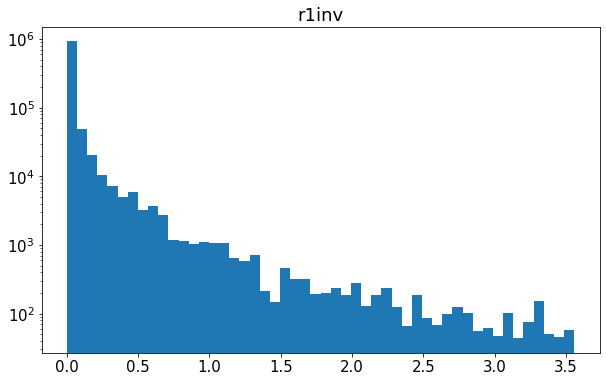

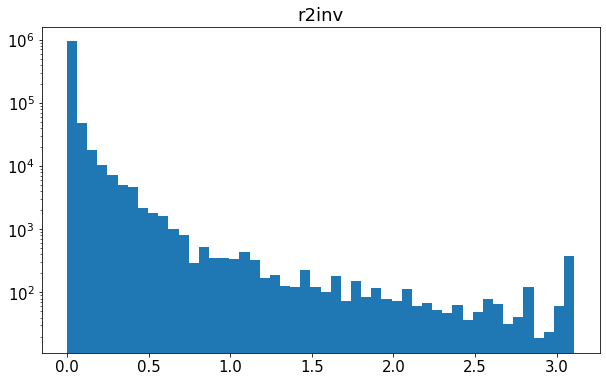

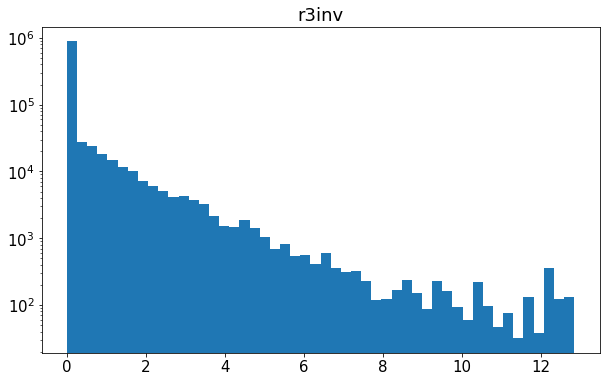

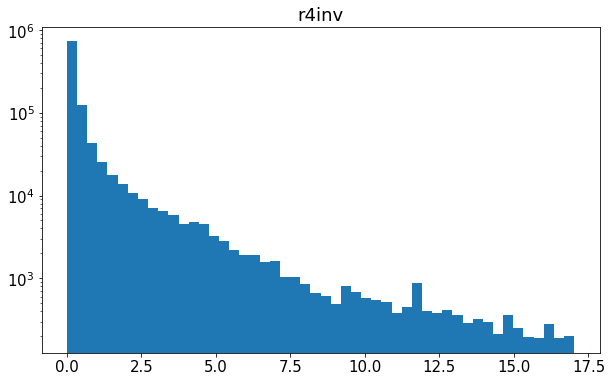

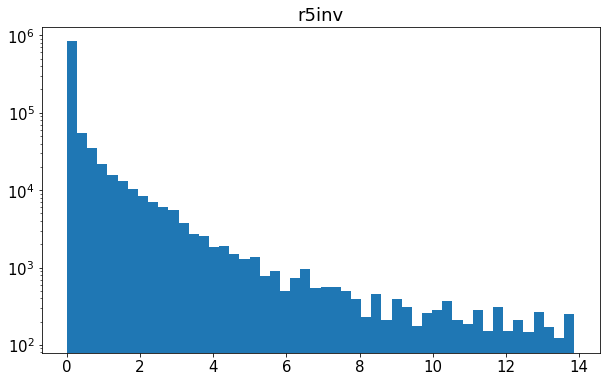

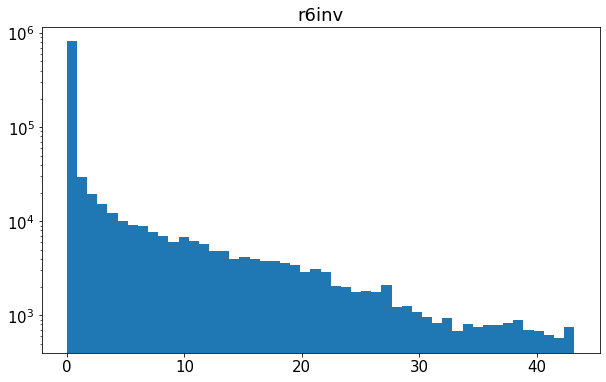

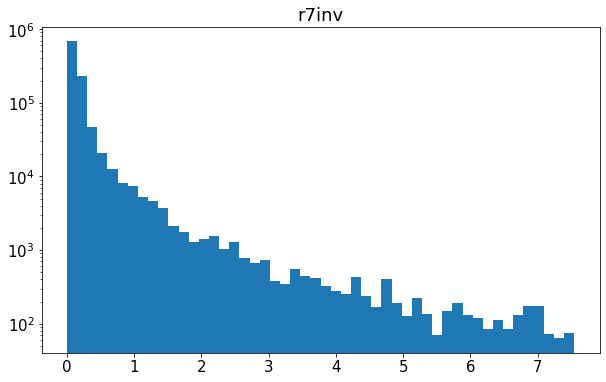

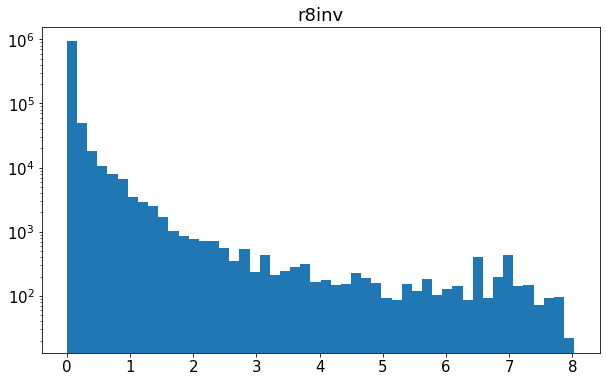

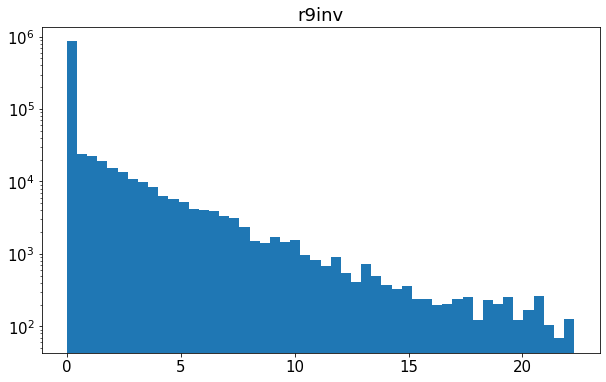

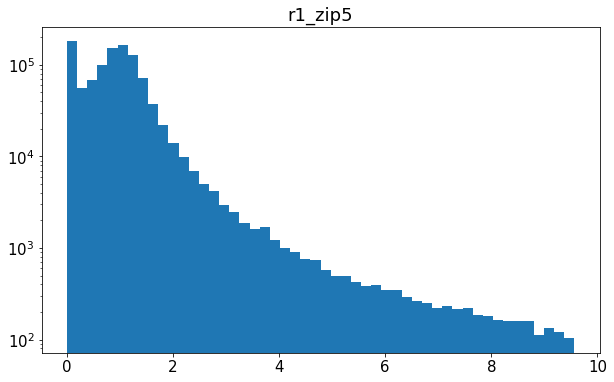

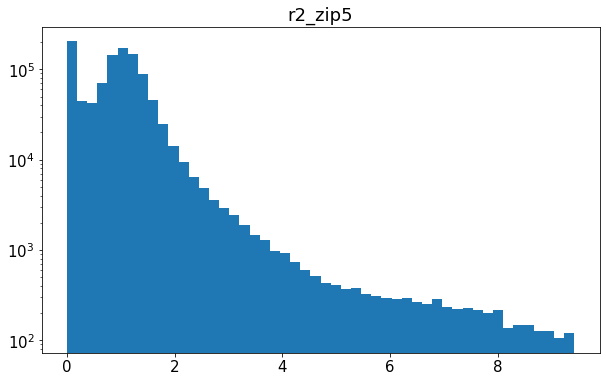

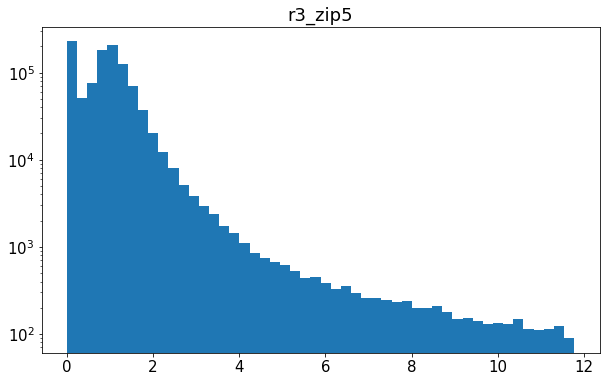

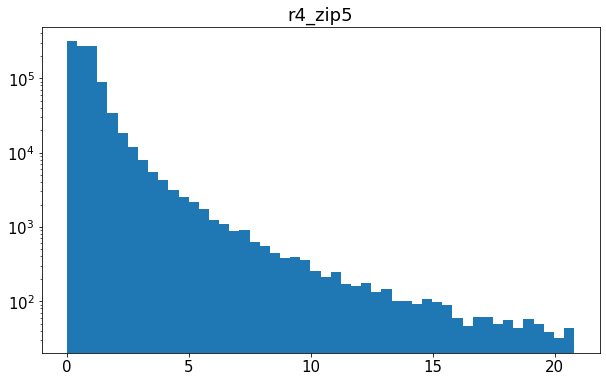

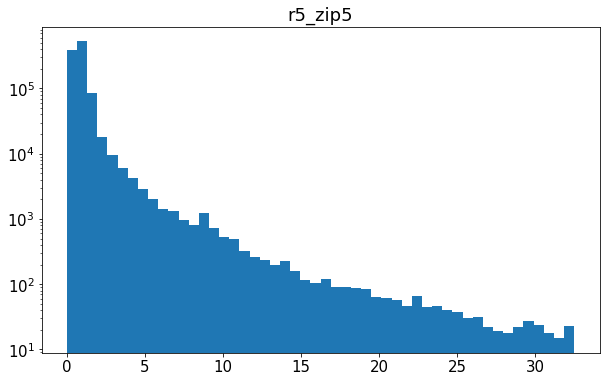

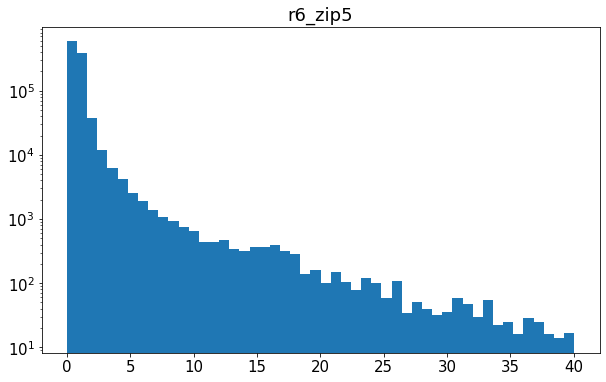

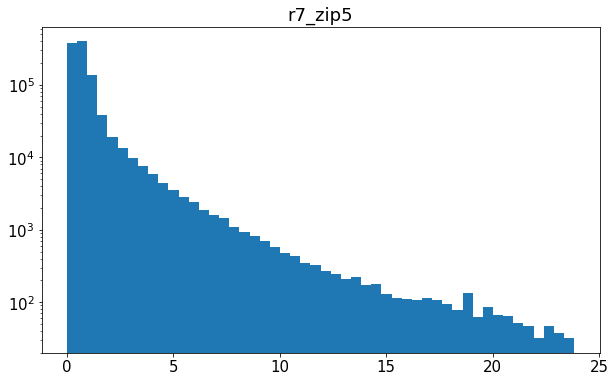

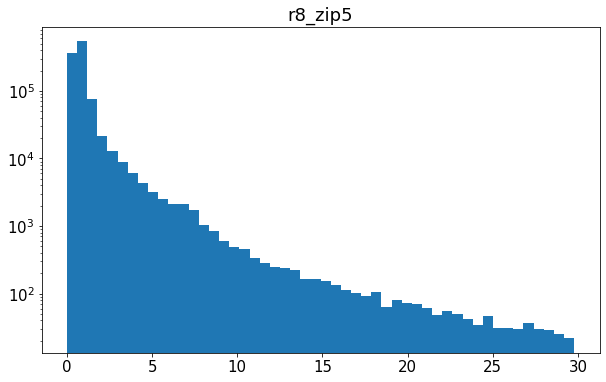

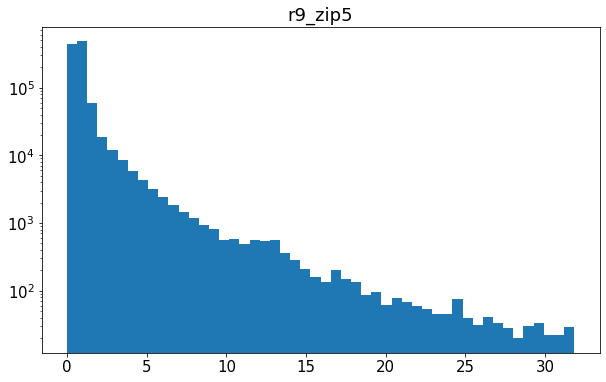

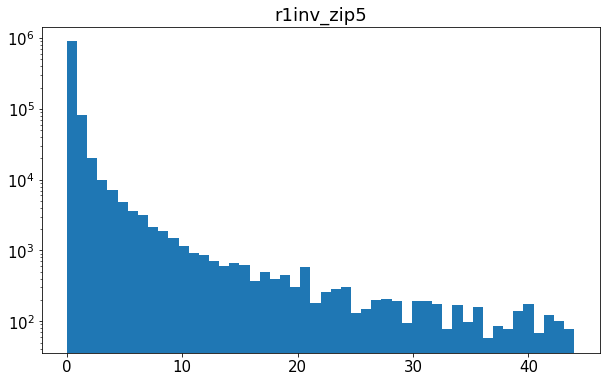

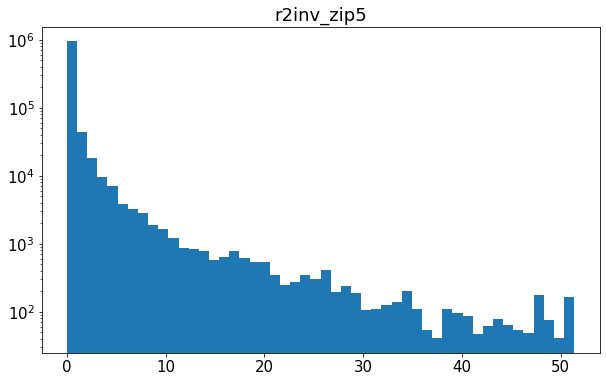

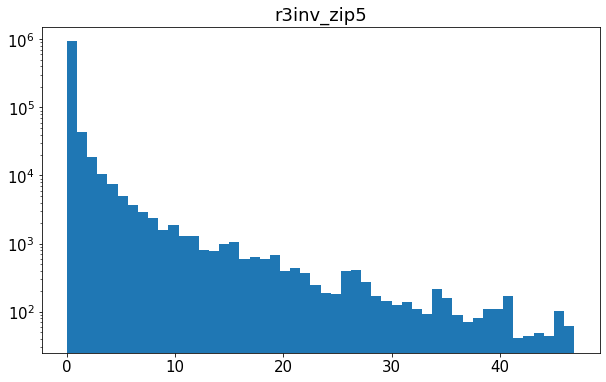

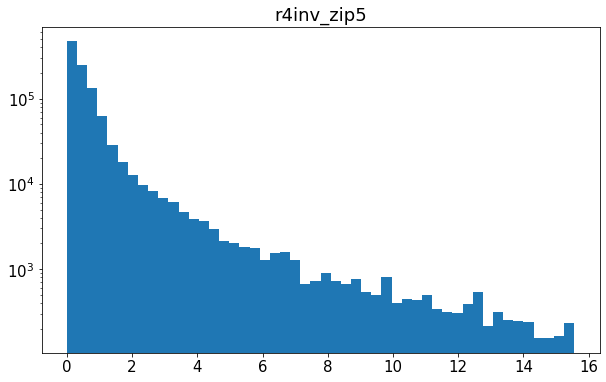

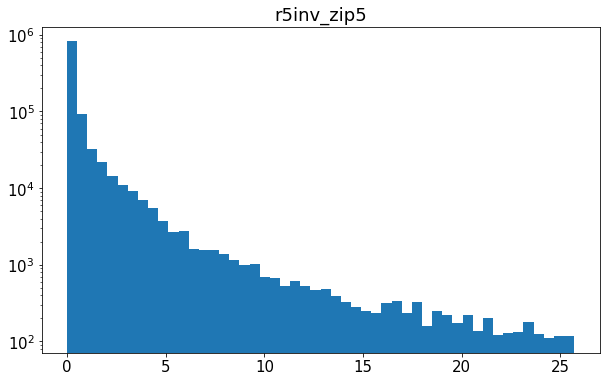

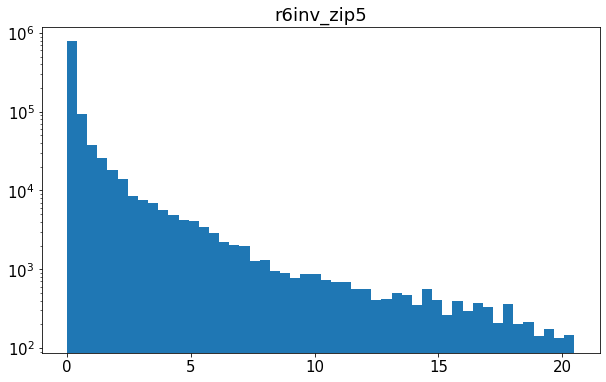

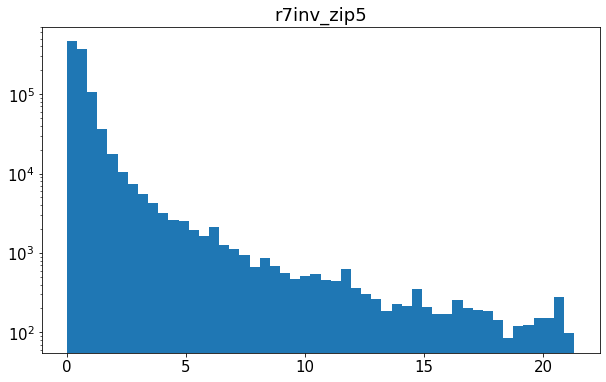

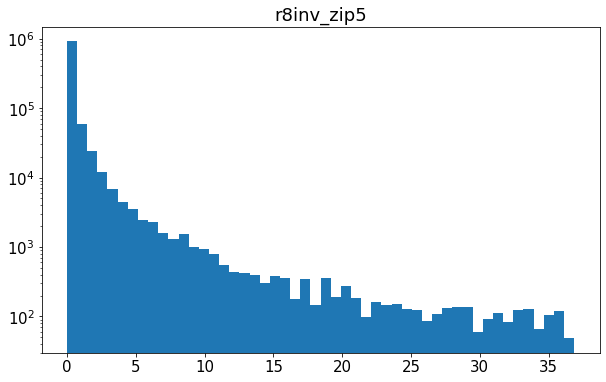

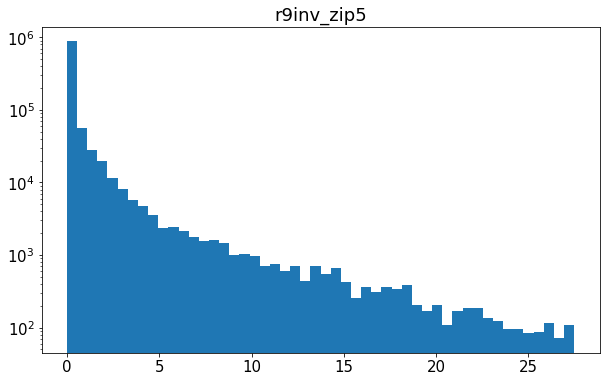

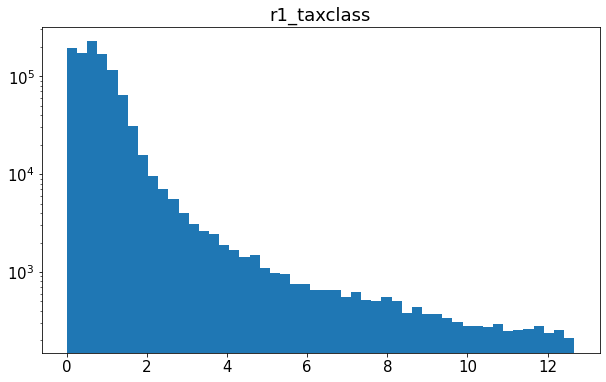

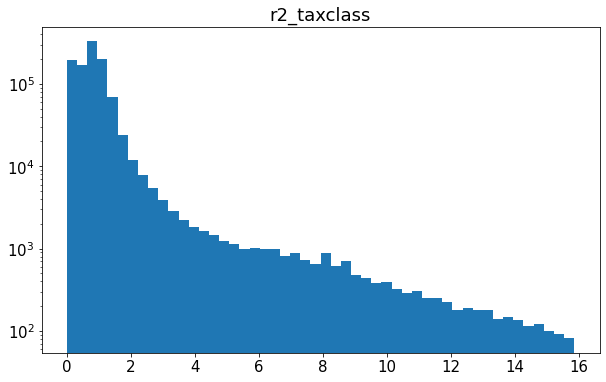

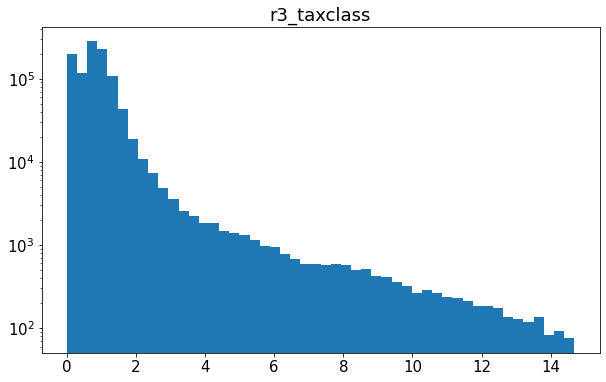

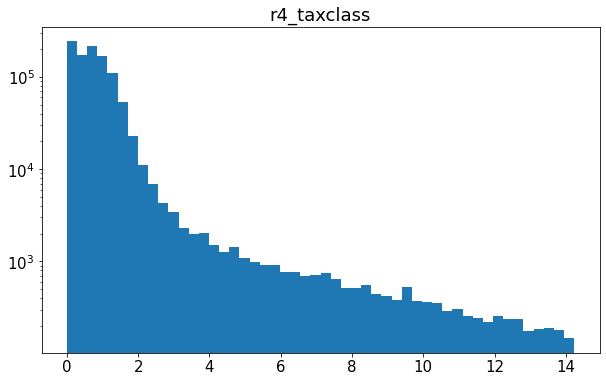

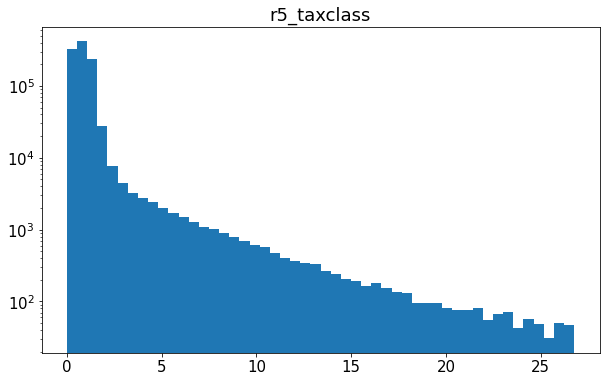

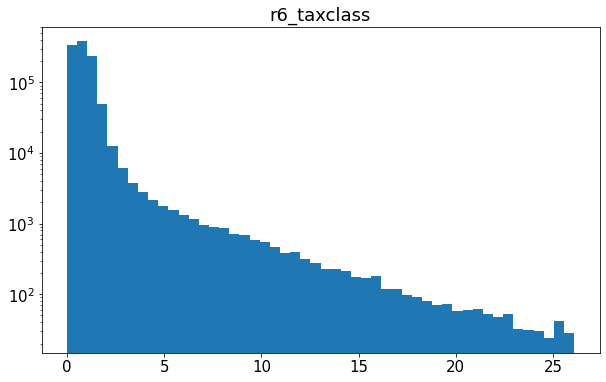

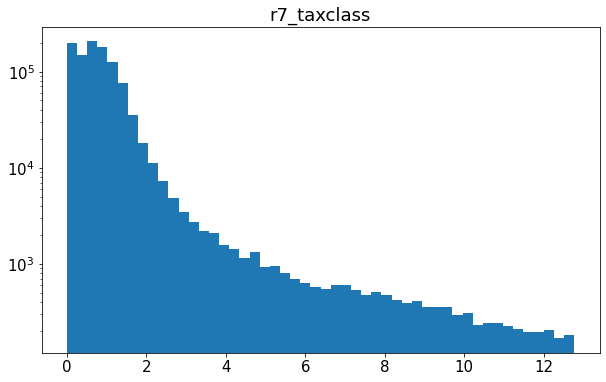

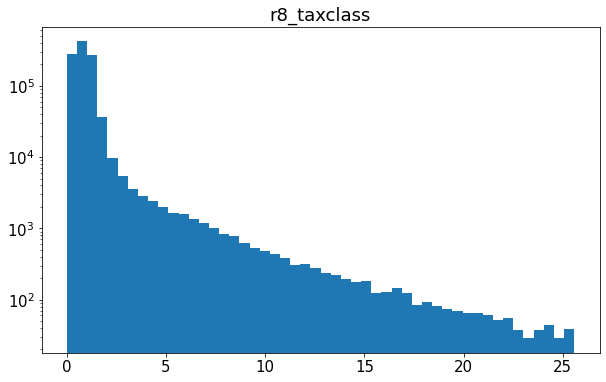

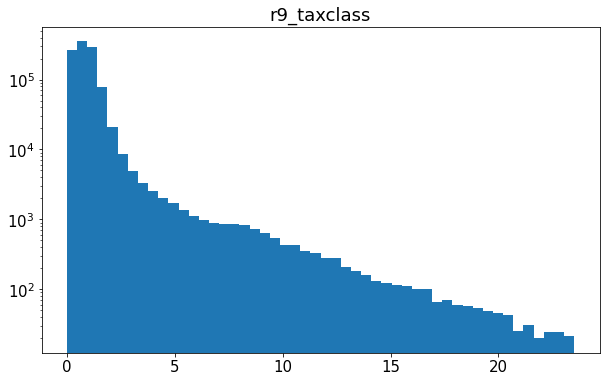

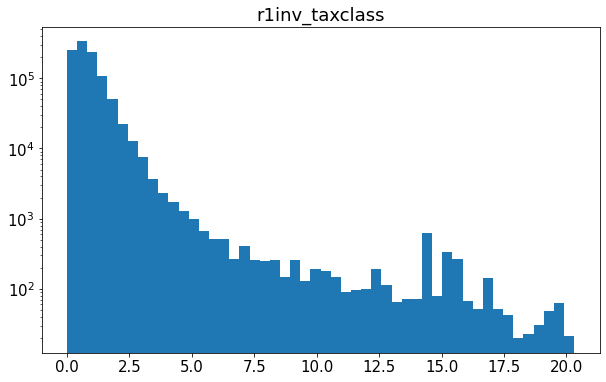

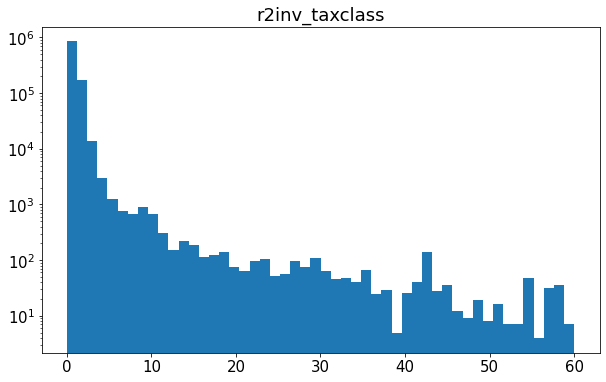

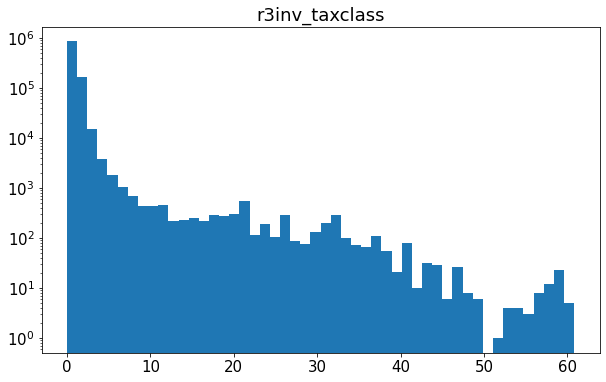

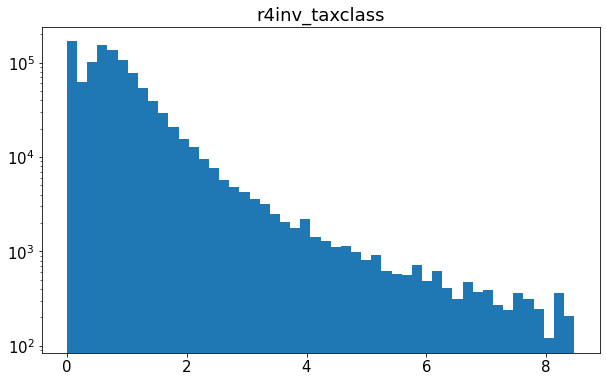

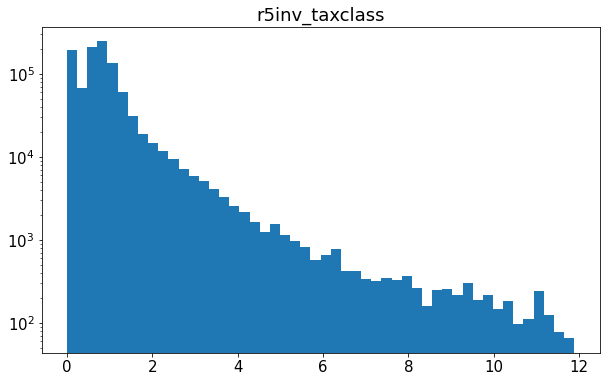

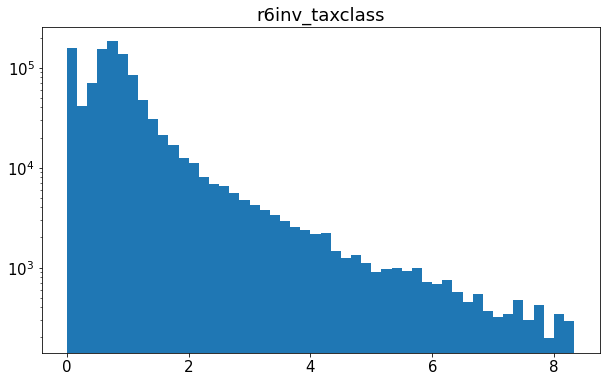

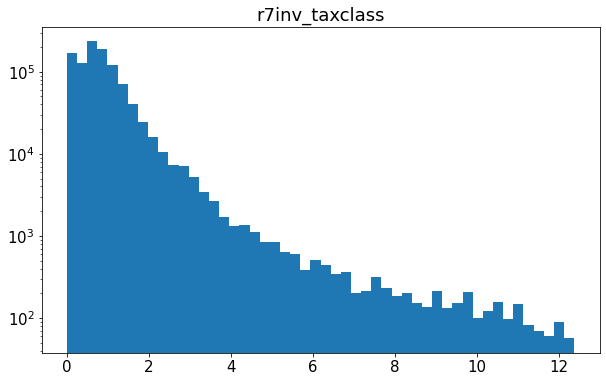

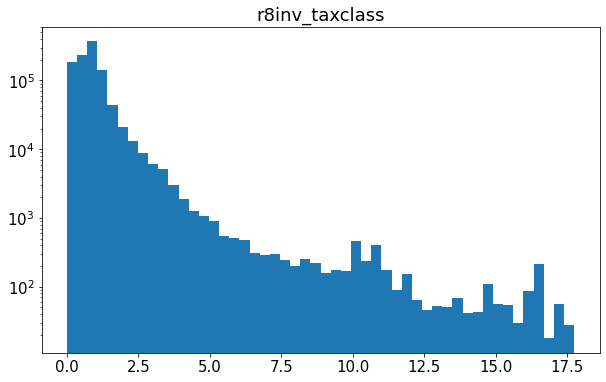

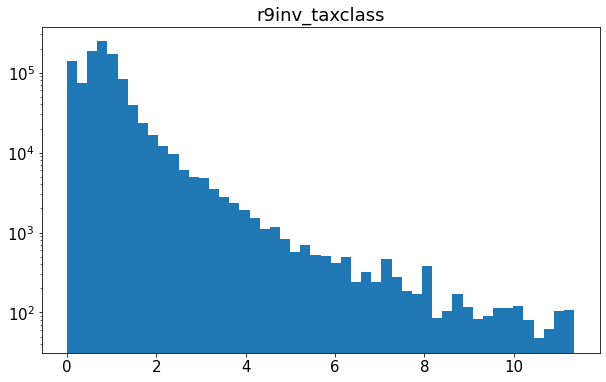

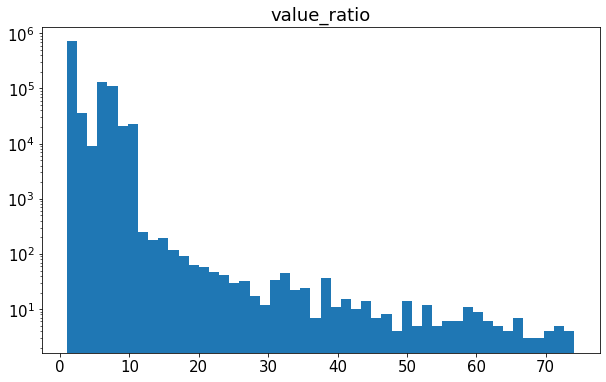

In [528]:
%%time
nstd = 4
for col in data.columns:
    plt.rcParams['figure.figsize'] = [10,6]
    plt.figure()
    plt.rcParams['font.size'] = 15
    plt.yscale('log')
    xstdev = data[col].std()
    xmean = data[col].mean()
    temp = data[data[col] <= xmean + nstd*xstdev]
    temp = temp[data[col] >= xmean - nstd*xstdev]
    plt.hist(temp[col],bins=50)
    plt.title(col)

In [529]:
#data.to_csv('NY vars.csv', index=False)

In [722]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r1inv_taxclass,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,...,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-1.012465e-16,-5.757583e-17,-1.442112e-17,-6.159527e-17,-9.305150e-18,-3.177534e-18,-3.584910e-17,1.163738e-17,-2.810895e-17,1.738138e-18,...,5.366502e-17,3.639227e-18,-5.241573e-18,1.520871e-17,1.318269e-16,9.342493e-18,7.908529e-17,5.692403e-17,1.622987e-16,-1.174058e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.039724e-01,-5.279251e-01,-5.013145e-01,-1.505693e-01,-6.081250e-02,-5.747917e-02,-1.328478e-01,-5.410804e-02,-5.868685e-02,-9.412311e-02,...,-2.066858e-01,-6.737479e-02,-6.636585e-02,-5.352064e-01,-3.669768e-01,-5.455804e-01,-3.516733e-01,-2.387159e-01,-3.861640e-01,-1.184163e-01
25%,-2.594624e-01,-3.189799e-01,-3.312695e-01,-1.166346e-01,-4.417025e-02,-4.582967e-02,-1.066404e-01,-3.531737e-02,-3.673350e-02,-8.940407e-02,...,-1.204850e-01,-3.279211e-02,-3.240578e-02,-3.169409e-01,-1.913549e-01,-2.773283e-01,-1.938550e-01,-1.064324e-01,-1.802704e-01,-1.115971e-01
50%,-1.146377e-01,-3.567583e-02,-9.924473e-03,-8.434234e-02,-2.069159e-02,-1.627775e-02,-9.028477e-02,-2.510215e-02,-1.948221e-02,-8.661308e-02,...,-5.642233e-02,-1.225936e-02,-1.318520e-02,-1.499729e-01,-8.985721e-02,-1.334652e-01,-9.356105e-02,-4.987762e-02,-8.146776e-02,-1.025660e-01
75%,5.618853e-02,1.453654e-01,1.897425e-01,-4.649066e-02,-6.489343e-03,4.138601e-04,-6.574734e-02,-1.540155e-02,-4.344369e-03,-7.907924e-02,...,2.607149e-02,6.739030e-03,6.637216e-03,7.141198e-02,1.905684e-02,3.749616e-02,3.581319e-02,1.451196e-02,2.872642e-02,1.639690e-01
max,2.563182e+02,3.053981e+02,4.670439e+02,3.171908e+02,8.965594e+02,6.432875e+02,3.142499e+02,9.373068e+02,8.985515e+02,1.105466e+02,...,4.098131e+02,7.626817e+02,7.751231e+02,1.905214e+02,4.414327e+02,3.483293e+02,2.128912e+02,4.726452e+02,4.228196e+02,5.616993e+02


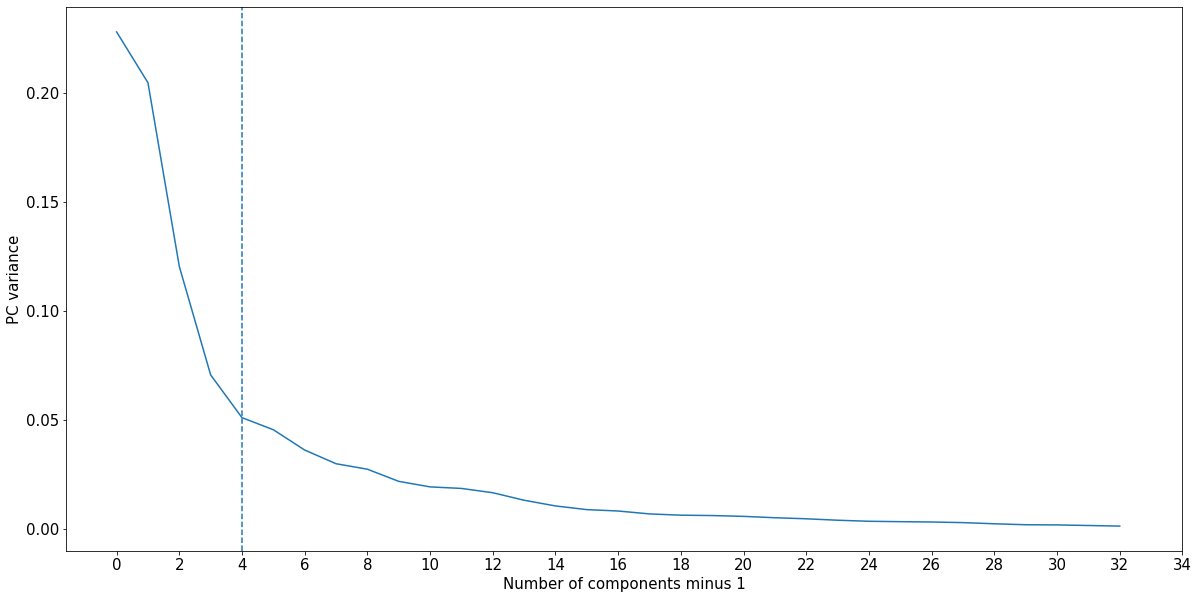

In [723]:
# do a PCA and look at the cumulative variance plot
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

(0.0, 1.0)

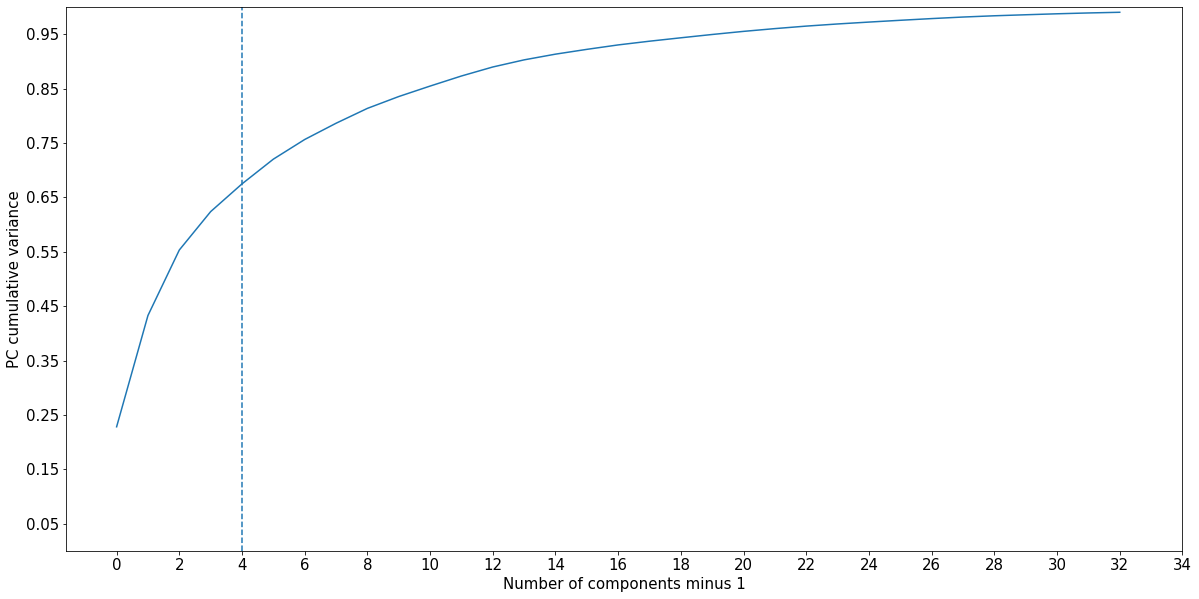

In [724]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [725]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 7, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 4.86 s, sys: 4.92 s, total: 9.78 s
Wall time: 5.02 s


7

In [726]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.22810334 0.43287532 0.55331733 0.62395743 0.67498154 0.72046282
 0.7566244 ]


In [727]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1046516, 7)

In [728]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,5.762073,4.043683,-1.891833,-0.222285,-0.180936,-4.094008,-0.505776
1,94.242879,63.636445,179.596821,3.007896,-6.043288,-29.677480,-12.693786
2,0.937990,-0.606501,0.702982,-0.376352,0.186457,0.322775,0.265732
3,1.398944,-0.277459,1.357972,-0.365917,0.160457,0.194611,0.211589
4,2.345865,0.399306,2.707152,-0.319498,0.085485,-0.428743,0.022900


In [729]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-1.825045e-17,-2.129219e-17,-5.583769e-17,3.476276e-17,-7.169820e-18,2.699546e-17,1.086336e-18
std,3.541989e+00,3.355959e+00,2.573774e+00,1.971092e+00,1.675209e+00,1.581604e+00,1.410279e+00
min,-3.278279e+02,-1.225691e+00,-6.416233e+02,-1.106217e+02,-2.867623e+02,-2.801124e+02,-1.249252e+02
25%,-1.133617e-01,-5.004919e-01,-4.244061e-01,-1.803371e-01,-9.868900e-02,-2.498552e-01,3.961743e-02
50%,2.929419e-01,-3.981551e-01,-2.057950e-01,4.949090e-02,3.927365e-02,-2.726129e-02,1.663953e-01
75%,5.441369e-01,-2.303800e-01,3.876411e-02,1.771724e-01,1.540944e-01,4.287885e-01,2.237820e-01
max,1.549127e+03,1.575223e+03,7.668906e+02,1.137730e+03,4.784196e+02,9.795296e+02,2.376012e+02


In [730]:
# zscale the pcs. This is an optional step, and I like to make all the retained PCs equally important.
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-5.757583e-18,3.367643e-18,2.172673e-19,-1.846772e-18,5.648949e-18,-2.444257e-19,-1.390511e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.255475e+01,-3.652283e-01,-2.492928e+02,-5.612202e+01,-1.711800e+02,-1.771066e+02,-8.858187e+01
25%,-3.200511e-02,-1.491353e-01,-1.648964e-01,-9.149096e-02,-5.891144e-02,-1.579759e-01,2.809191e-02
50%,8.270550e-02,-1.186412e-01,-7.995848e-02,2.510836e-02,2.344402e-02,-1.723649e-02,1.179875e-01
75%,1.536247e-01,-6.864804e-02,1.506119e-02,8.988538e-02,9.198516e-02,2.711100e-01,1.586792e-01
max,4.373608e+02,4.693809e+02,2.979635e+02,5.772081e+02,2.855880e+02,6.193268e+02,1.684781e+02


In [731]:
data_pca_zs.shape

(1046516, 7)

In [732]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1.626790,1.204926,-0.735042,-0.112772,-0.108008,-2.588517,-0.358635
1,26.607335,18.962225,69.779574,1.526005,-3.607482,-18.764170,-9.000903
2,0.264820,-0.180723,0.273133,-0.190936,0.111303,0.204081,0.188425
3,0.394960,-0.082677,0.527619,-0.185642,0.095783,0.123047,0.150033
4,0.662302,0.118984,1.051822,-0.162092,0.051030,-0.271081,0.016238


## Now calculate two unsupervised fraud scores

In [733]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
# Good choices are anywhere from 1 to about 4.
p1 = 3.5
p2 = 3.5
ntop = 100

### Calculate score 1

In [734]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0     2.776949
1    70.866384
2     0.377199
3     0.582186
4     1.110367
5     0.435118
6     0.372351
7     0.377942
8     0.874341
9     0.844220
dtype: float64

In [735]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1.626790,1.204926,-0.735042,-0.112772,-0.108008,-2.588517,-0.358635
1,26.607335,18.962225,69.779574,1.526005,-3.607482,-18.764170,-9.000903
2,0.264820,-0.180723,0.273133,-0.190936,0.111303,0.204081,0.188425
3,0.394960,-0.082677,0.527619,-0.185642,0.095783,0.123047,0.150033
4,0.662302,0.118984,1.051822,-0.162092,0.051030,-0.271081,0.016238
5,0.027884,-0.323387,-0.149405,-0.188286,0.140803,0.347691,0.221161
6,0.140833,-0.267847,0.037834,-0.193814,0.126315,0.280603,0.218454
7,0.130832,-0.274235,0.019581,-0.193827,0.127548,0.286705,0.220211
8,0.543930,0.032195,0.821929,-0.178671,0.078114,0.030004,0.103332
9,0.528854,0.020502,0.792067,-0.179400,0.079900,0.039427,0.108130


In [736]:
score1.max()

722.9394417799625

### Autoencoder for score 2

In [737]:
%%time
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

CPU times: user 45 s, sys: 274 ms, total: 45.3 s
Wall time: 46 s


/Users/abhishekpanisetty/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [738]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [739]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,2.776949,2.190753,1
1,70.866384,52.730279,2
2,0.377199,0.266221,9
3,0.582186,0.367135,10
4,1.110367,0.703458,11
5,0.435118,0.271979,12
6,0.372351,0.250216,13
7,0.377942,0.251207,14
8,0.874341,0.544760,15
9,0.844220,0.525600,16


In [740]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,2.776949,2.190753,1,1019305.0,1030089.0
1,70.866384,52.730279,2,1046434.0,1046420.0
2,0.377199,0.266221,9,605545.0,645771.0
3,0.582186,0.367135,10,853827.0,839865.0
4,1.110367,0.703458,11,969314.0,975444.0
5,0.435118,0.271979,12,670144.0,663264.0
6,0.372351,0.250216,13,599888.0,605066.0
7,0.377942,0.251207,14,606356.0,607576.0
8,0.874341,0.544760,15,940129.0,943707.0
9,0.844220,0.525600,16,935307.0,937956.0


In [741]:
# calculate the final score as the average of the two scores
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
0,2.776949,2.190753,1,1019305.0,1030089.0,1024697.0
1,70.866384,52.730279,2,1046434.0,1046420.0,1046427.0
2,0.377199,0.266221,9,605545.0,645771.0,625658.0
3,0.582186,0.367135,10,853827.0,839865.0,846846.0
4,1.110367,0.703458,11,969314.0,975444.0,972379.0
5,0.435118,0.271979,12,670144.0,663264.0,666704.0
6,0.372351,0.250216,13,599888.0,605066.0,602477.0
7,0.377942,0.251207,14,606356.0,607576.0,606966.0
8,0.874341,0.544760,15,940129.0,943707.0,941918.0
9,0.844220,0.525600,16,935307.0,937956.0,936631.5


In [742]:
scores_sorted.head(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
898718,722.939442,722.535313,917942,1046516.0,1046516.0,1046516.0
935946,591.845580,600.348403,956520,1046515.0,1046515.0,1046515.0
642107,508.811643,516.761932,658933,1046514.0,1046514.0,1046514.0
1036106,305.637037,286.672673,1059883,1046513.0,1046513.0,1046513.0
137438,233.141801,211.420760,139726,1046512.0,1046512.0,1046512.0
115113,219.240813,196.897771,116647,1046511.0,1046510.0,1046510.5
320921,201.971850,204.321905,333412,1046509.0,1046511.0,1046510.0
667756,209.984141,187.637153,684704,1046510.0,1046509.0,1046509.5
648311,195.548853,186.481774,665158,1046508.0,1046508.0,1046508.0
148112,183.580701,171.931486,151044,1046507.0,1046506.0,1046506.5


In [743]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
765270,0.152288,0.045143,782924,2493.0,9287.0,5890.0
771462,0.140876,0.046942,789120,379.0,10833.0,5606.0
439881,0.125388,0.046650,455028,20.0,10580.0,5300.0
757183,0.117064,0.046334,774709,3.0,10323.0,5163.0
432477,0.160557,0.034595,447562,6990.0,2963.0,4976.5
432478,0.159161,0.035732,447563,5940.0,3540.0,4740.0
742103,0.158275,0.032121,759546,5347.0,2133.0,3740.0
337437,0.146199,0.038435,350236,919.0,4949.0,2934.0
340466,0.144132,0.038654,353276,677.0,5046.0,2861.5
402886,0.122679,0.039761,417674,11.0,5606.0,2808.5


In [744]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,5.988962e-01,3.567016e-01,5.370414e+05,5.232585e+05,5.232585e+05,5.232585e+05
std,2.093319e+00,1.685398e+00,3.080583e+05,3.021033e+05,3.021033e+05,2.959745e+05
min,1.058929e-01,1.240219e-02,1.000000e+00,1.000000e+00,1.000000e+00,2.808500e+03
25%,2.141606e-01,1.262041e-01,2.731068e+05,2.616285e+05,2.616298e+05,2.523345e+05
50%,3.127840e-01,2.088824e-01,5.389795e+05,5.232585e+05,5.232585e+05,5.193365e+05
75%,4.967061e-01,3.274071e-01,8.026112e+05,7.848872e+05,7.848985e+05,7.671552e+05
max,7.229394e+02,7.225353e+02,1.070994e+06,1.046516e+06,1.046516e+06,1.046516e+06


In [745]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,5.988962e-01,3.567016e-01,5.370414e+05,5.232585e+05,5.232585e+05,5.232585e+05
std,2.093319e+00,1.685398e+00,3.080583e+05,3.021033e+05,3.021033e+05,2.959745e+05
min,1.058929e-01,1.240219e-02,1.000000e+00,1.000000e+00,1.000000e+00,2.808500e+03
25%,2.141606e-01,1.262041e-01,2.731068e+05,2.616285e+05,2.616298e+05,2.523345e+05
50%,3.127840e-01,2.088824e-01,5.389795e+05,5.232585e+05,5.232585e+05,5.193365e+05
75%,4.967061e-01,3.274071e-01,8.026112e+05,7.848872e+05,7.848985e+05,7.671552e+05
max,7.229394e+02,7.225353e+02,1.070994e+06,1.046516e+06,1.046516e+06,1.046516e+06


In [746]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,722.939442,722.535313,1046516.0,1046516.0,1046516.0
956520,591.845580,600.348403,1046515.0,1046515.0,1046515.0
658933,508.811643,516.761932,1046514.0,1046514.0,1046514.0
1059883,305.637037,286.672673,1046513.0,1046513.0,1046513.0
139726,233.141801,211.420760,1046512.0,1046512.0,1046512.0
116647,219.240813,196.897771,1046511.0,1046510.0,1046510.5
333412,201.971850,204.321905,1046509.0,1046511.0,1046510.0
684704,209.984141,187.637153,1046510.0,1046509.0,1046509.5
665158,195.548853,186.481774,1046508.0,1046508.0,1046508.0


(0.1, 2077668.3239038493)

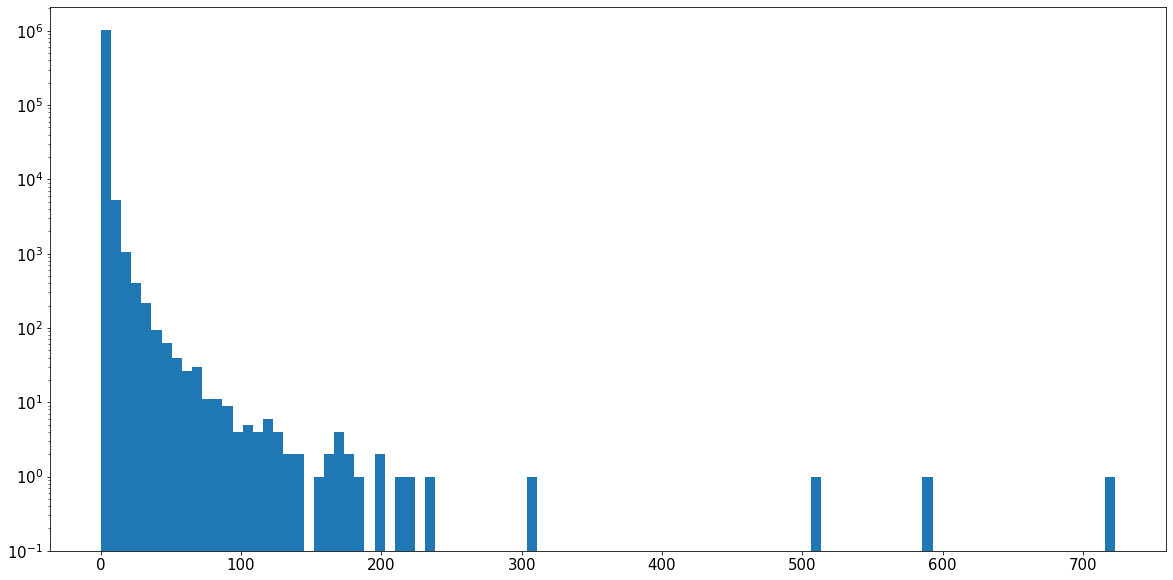

In [747]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [748]:
sc2max = int(score2.max())
sc2max

722

722


(0.1, 2088227.905514497)

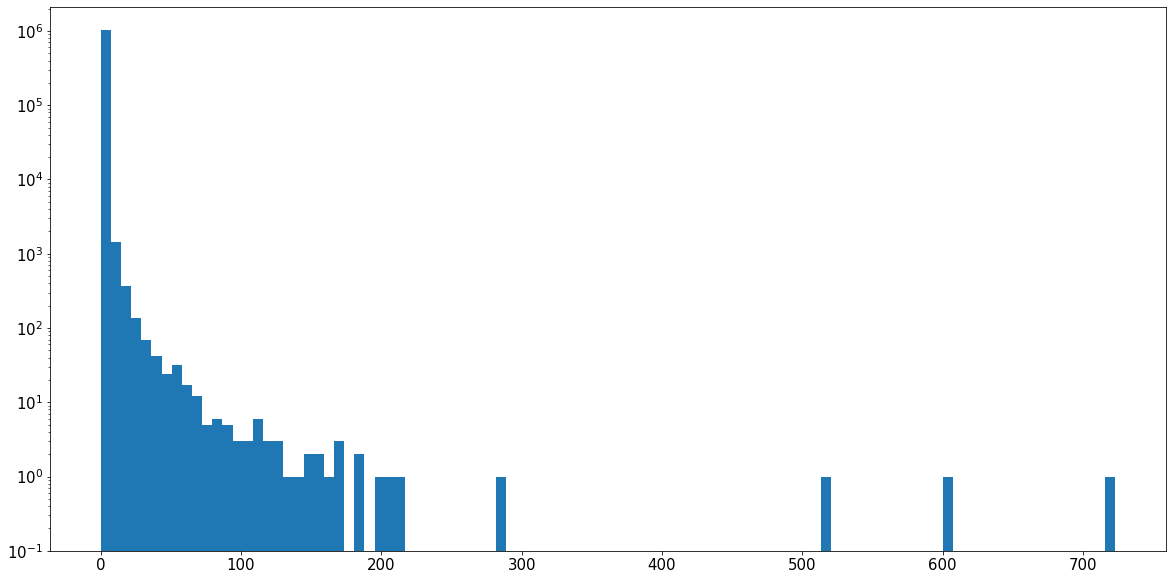

In [749]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

(array([  222.,  1495.,  3797.,  6360.,  8574.,  9896., 11485., 13210.,
        14064., 14511., 15008., 15079., 15084., 14035., 13855., 13469.,
        12736., 12922., 11624., 11720., 11082., 10682., 10846., 10836.,
        10269., 10897., 10358., 10459., 10044.,  9944.,  9969.,  9932.,
         9992.,  9702., 10366., 10074., 10330., 10685., 10383., 10647.,
        10704., 10656., 10197.,  9936., 10490., 10035., 10084., 10147.,
         9691.,  9724.,  9388.,  9281.,  9121.,  8544.,  8355.,  8135.,
         8000.,  7731.,  7363.,  7730.,  7541.,  8238.,  8703.,  9769.,
        10855., 12602., 15905., 16502., 18353., 18252., 16137., 14268.,
        13004., 11860., 10564., 10045., 10107., 10099.,  9753.,  9420.,
         9171.,  9777.,  9588.,  9337., 10337.,  9521.,  9738., 10212.,
        10402.,  9590.,  9019.,  9230.,  9203.,  9416.,  9175.,  8833.,
         9753.,  9945., 10488.,  9849.]),
 array([   2808.5  ,   13245.575,   23682.65 ,   34119.725,   44556.8  ,
          54993.875, 

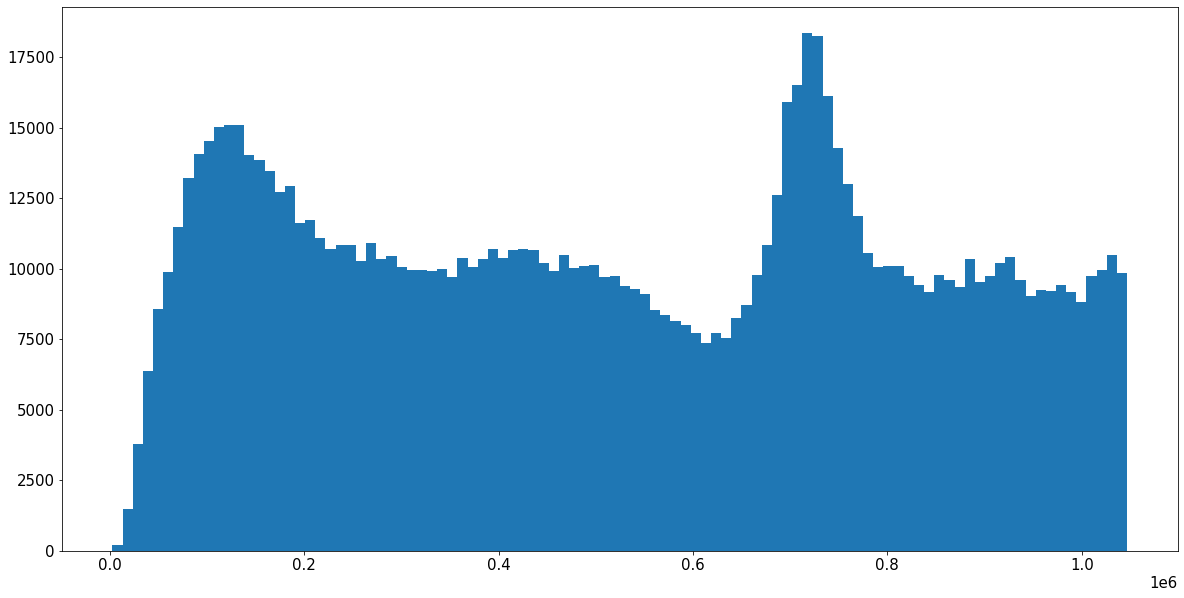

In [750]:
plt.hist(scores['final'],bins=100)

In [751]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Int64Index([ 917942,  956520,  658933, 1059883,  139726,  116647,  333412,
             684704,  665158,  151044,   12076,  252834,  382398,  649717,
             980276,  330291,  982930,  845810,  106681,  934793,   33751,
             665157,  638993,   39770,  610682,  373564,   33564,  288274,
             691986,  243059, 1065870,  844895,   95995,  871048,  330292,
             979038,  718883,   86946,  803040,  649675,  866431,     420,
              14979,  820884,   47984,    7054,  976655,   48221,  216948,
             448369,  991517,  223485,  996722,   60469,  995567,  839956,
             627564,  106723,  994819,  994815,  994813,  994817,  155893,
              56136,  817349,  994821,   88389,  752488,  519315,  519314,
             992071,  712085,  771150,     428,  981751,  244527,   56969,
              85962,  114694,    7056,  643751,   41924, 1049911,  649812,
             843845,  581146,  459429, 1062743,  104411,  163980, 1000954,
                  2, 1005

In [752]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r1inv_taxclass,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
1,-0.326552,3.406992,0.987422,-0.034199,2.052445,0.766972,-0.041524,1.879522,0.949207,-0.066039,...,-0.193824,-0.067325,-0.066321,-0.512577,-0.366754,-0.545038,-0.327433,-0.238511,-0.385804,0.267780
2,108.917366,35.106980,12.980793,61.297815,7.095909,2.734592,128.820205,17.456997,9.068879,-0.094112,...,-0.206681,-0.067370,-0.066361,-0.535172,-0.366912,-0.545421,-0.351663,-0.238694,-0.386125,0.188881
9,0.327495,0.197416,-0.471032,0.747304,0.257310,-0.043784,0.729977,0.302327,-0.038185,-0.091157,...,-0.205328,-0.067101,-0.064141,-0.532278,-0.365497,-0.513024,-0.349113,-0.237603,-0.368462,0.244919
10,0.653138,0.520331,-0.457550,1.147030,0.398936,-0.037686,1.114097,0.461008,-0.029058,-0.092074,...,-0.205747,-0.067185,-0.064826,-0.533182,-0.365953,-0.523024,-0.349904,-0.237946,-0.373909,0.244919
11,1.561562,1.421145,-0.419941,1.215100,0.423053,-0.036648,2.185654,0.903671,-0.003596,-0.093025,...,-0.206183,-0.067273,-0.065538,-0.533284,-0.366004,-0.524145,-0.350725,-0.238302,-0.379570,0.200154


In [753]:
data_zs_top_n = data_zs.loc[top_records]
data_zs_top_n.transpose()

RECORD,917942,956520,658933,1059883,139726,116647,333412,684704,665158,151044,...,1000954,2,1005901,942462,981883,64271,7039,7034,7041,7040
r1,0.756214,-0.114376,0.183338,204.973756,256.318188,162.065400,-0.392110,176.589777,-0.388437,6.052530,...,-0.403971,108.917366,-0.352520,-0.403925,-0.403376,80.442559,-0.403971,-0.403971,-0.403971,-0.403971
r2,68.244847,-0.527888,-0.527871,-0.028963,-0.028963,4.437754,-0.527873,-0.415113,133.268367,305.398109,...,-0.527907,35.106980,45.660307,-0.527885,-0.523391,79.641419,-0.527924,-0.527924,-0.527924,-0.527924
r3,47.353074,-0.501288,-0.501277,-0.312537,-0.312537,-0.205147,-0.501278,-0.442440,278.798453,105.935454,...,-0.501308,12.980793,23.603170,-0.501299,-0.491848,2.541476,-0.501314,-0.501314,-0.501314,-0.501314
r4,42.183218,-0.051803,0.004642,253.722524,317.190798,147.455998,-0.111954,32.895634,-0.097632,2.175770,...,-0.150562,61.297815,-0.147745,-0.150405,-0.150460,51.535885,-0.150567,-0.150567,-0.150567,-0.150567
r5,896.559351,-0.060808,-0.060808,0.159563,0.159563,1.551116,-0.060752,-0.053287,162.835033,39.323661,...,-0.060791,7.095909,0.845153,-0.060764,-0.060516,18.252067,-0.060812,-0.060812,-0.060812,-0.060812
r6,643.287451,-0.057476,-0.057476,0.028497,0.028497,0.041657,-0.057435,-0.053429,350.586709,14.072139,...,-0.057470,2.734592,0.430059,-0.057460,-0.056839,0.659243,-0.057479,-0.057479,-0.057479,-0.057479
r7,37.825491,-0.087301,-0.040477,251.373336,314.249882,191.512459,-0.118854,11.251048,-0.114522,7.483102,...,-0.132845,128.820205,-0.131875,-0.132791,-0.132809,95.231947,-0.132844,-0.132844,-0.132844,-0.132844
r8,937.306848,-0.054106,-0.054105,0.200443,0.200443,2.386043,-0.054082,-0.051086,65.693812,150.278910,...,-0.054099,17.456997,0.309626,-0.054088,-0.053985,39.341360,-0.054107,-0.054107,-0.054107,-0.054107
r9,898.551545,-0.058685,-0.058684,0.073996,0.073996,0.141822,-0.058662,-0.056514,189.030971,72.000421,...,-0.058682,9.068879,0.202836,-0.058677,-0.058333,2.001323,-0.058687,-0.058687,-0.058687,-0.058687
r1inv,-0.092256,-0.086620,-0.090428,-0.094121,-0.094123,-0.094118,0.088957,-0.094119,0.045731,-0.093795,...,103.151298,-0.094112,-0.051866,32.354760,3.434171,-0.094105,102.261383,102.261383,102.261383,102.261383


In [754]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
1,1019305.0,1030089.0,1024697.0
2,1046434.0,1046420.0,1046427.0
9,605545.0,645771.0,625658.0
10,853827.0,839865.0,846846.0
11,969314.0,975444.0,972379.0
12,670144.0,663264.0,666704.0
13,599888.0,605066.0,602477.0
14,606356.0,607576.0,606966.0
15,940129.0,943707.0,941918.0


In [755]:
# NY_data_with_scores = NY_data_orig.join(scores, on='RECORD', rsuffix='_scores')
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1019305.0,1030089.0,1024697.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046434.0,1046420.0,1046427.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,561182.0,378563.0,469872.5
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,973663.0,610522.0,792092.5
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,933084.0,579821.0,756452.5
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,646316.0,569892.0,608104.0


In [756]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_and_sorted.set_index('RECORD',inplace=True)
NY_data_top_n = NY_data_scored_and_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1046516.0,1046516.0,1046516.0
956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,91,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046515.0,1046515.0,1046515.0
658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,100,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046514.0,1046514.0,1046514.0
1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5,5,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046513.0,1046513.0,1046513.0
139726,1020440122,1,2044,122,NaN,"BRADHURST EQUITIES, L",V1,4,4,5,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046512.0,1046512.0,1046512.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64271,1010491004,1,1049,1004,NaN,AOL TIME WARNER REALT,R5,4,0,0,...,1.553498e+08,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046425.0,1046406.0,1046415.5
7033,1000531145,1,53,1145,NaN,NaN,R4,2,0,0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046415.0,1046412.0,1046413.5
7034,1000531146,1,53,1146,NaN,"HSIA, JONATHAN",R4,2,0,0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046415.0,1046412.0,1046413.5


In [757]:
NY_data_with_scores.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1019305.0,1030089.0,1024697.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046434.0,1046420.0,1046427.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
5,6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,...,4268700.0,4268700.0,4268700.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
6,7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,...,3546900.0,3546900.0,3546900.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
7,8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,...,11304000.0,9882000.0,11304000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
8,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,605545.0,645771.0,625658.0
9,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,853827.0,839865.0,846846.0


In [758]:
NY_data_top_n['OWNER'].head(40)

RECORD
917942      LOGAN PROPERTY, INC.
956520         TROMPETA RIZALINA
658933           WAN CHIU CHEUNG
1059883                      NaN
139726     BRADHURST EQUITIES, L
116647      MF ASSOCIATES OF NEW
333412            SPOONER ALSTON
684704                  W RUFERT
665158         ST JOHNS CEMETERY
151044                       NaN
12076      15 WORTH STREET PROPE
252834                       NaN
382398            MARINO FRANK R
649717                 57-43 LLC
980276     WOODMONT WEST HOA INC
330291           PRATT INSTITUTE
845810           WILLIAM A. LOTT
982930     FOREST VIEW HOMEOWNER
106681           79TH REALTY LLC
33751             GUIDARA, FRANK
934793     BREEZY POINT COOPERAT
665157         ST JOHNS CEMETERY
638993     ALEXANDER'S OF REGOPA
39770      GREENHORN DEVELOPMENT
610682            DEBORAH WILSON
33564        HLP PROPERTIES, LLC
288274                       NaN
373564               J BRENOWITZ
691986     TITAN SOUNDVIEW POINT
243059      SILVER BEACH GARDENS
106

In [759]:
NY_data_top_n.shape

(100, 34)

In [760]:
data_zs_top_n.shape

(100, 55)

In [761]:
NY_top_with_zs = pd.concat([NY_data_top_n,data_zs_top_n],axis=1)
NY_top_with_zs.shape

(103, 89)

In [762]:
# NY_top_with_zs.to_excel('NY_top_with_zs.xlsx', index=True)
# NY_data_top_n.to_excel('NY_top.xlsx', index=True)
# data_zs_top_n.to_csv('data_zs_top.csv', index=True)

In [763]:
data_zs_top_n.shape

(100, 55)

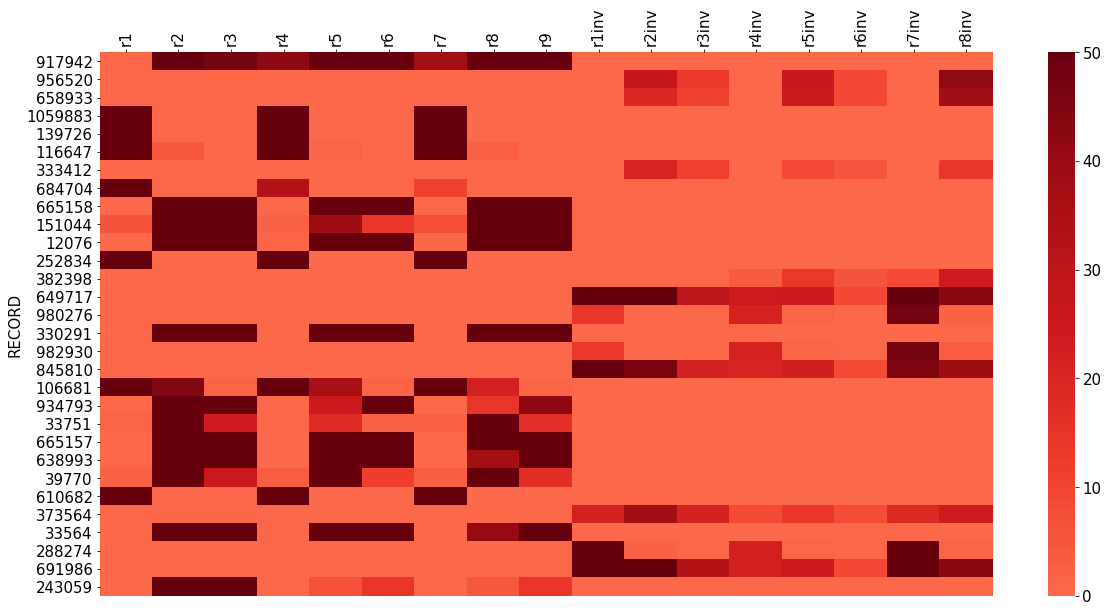

In [764]:
# The heatmaps are good for seeing which variables are driving the high scores
data_base_vars = data_zs_top_n.iloc[:,0:17].abs()
data_heatmap = data_base_vars.head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

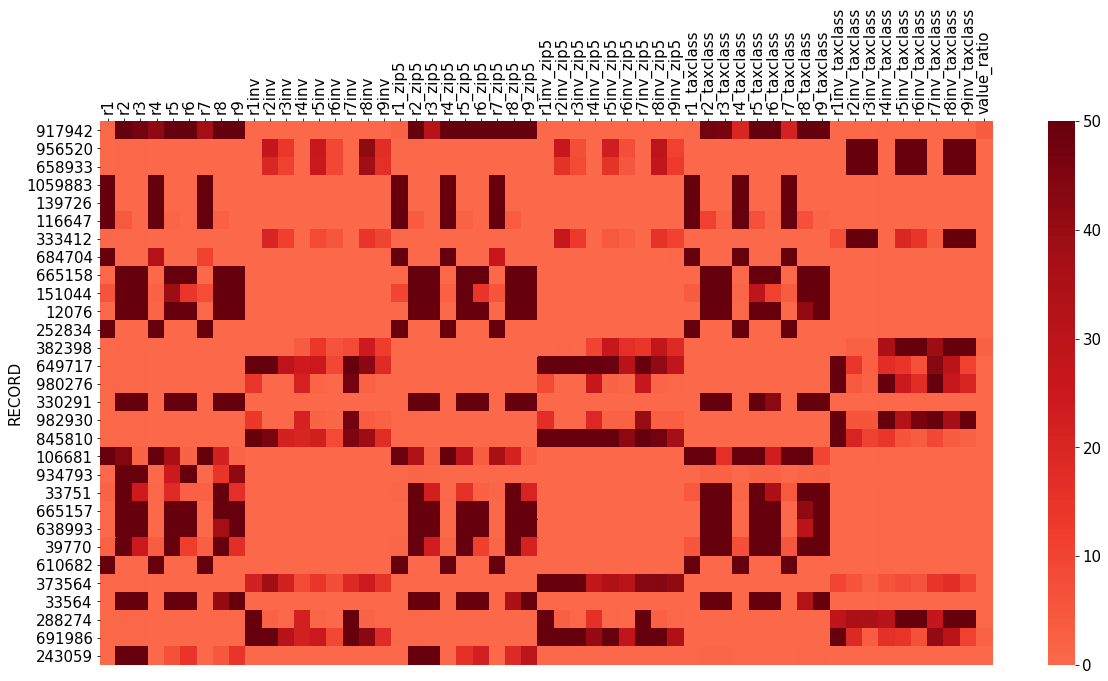

In [765]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [766]:
top_records_df = pd.DataFrame(top_records)

In [767]:
# Use this cell if you want to write out the top n record numbers
#top_records_df.to_csv('top_n_record_numbers.csv', index=False)

In [768]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

top_records_previous = pd.read_csv('top_n_record_numbers.csv')
print(top_records_df.head())
print(top_records_previous.head())
num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
percent_common = 100*num_common/ntop
percent_common

    RECORD
0   917942
1   956520
2   658933
3  1059883
4   139726
    RECORD
0   917942
1   956520
2   658933
3  1059883
4   665158


100.0

In [769]:
# about 4 minutes
print('Duration: ', datetime.now() - start_time)

Duration:  0:21:37.715346
